# Analyzing Monte Carlo Simulations

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv("data/mc_dac.txt", sep=" +", engine='python')
data.columns = ["net1", "iout", "idump", "i_in"]
data["bit"] = data.index
data.head()

,net1,iout,idump,i_in,bit
0,0.040797,3.640485e-14,1.007639e-06,0.000001,0
1,0.040773,1.331933e-08,9.943199e-07,0.000001,1
2,0.040765,1.848876e-08,9.891506e-07,0.000001,2
3,0.040743,2.994010e-08,9.776995e-07,0.000001,3
4,0.040765,2.882275e-08,9.788166e-07,0.000001,4


real 1bit current:         1.33193277e-08
theoretical 1bit current:  7.8125e-09


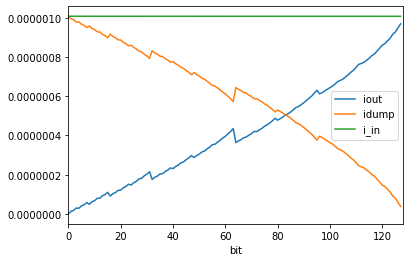

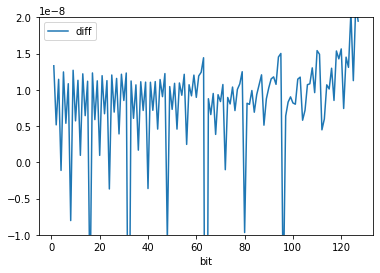

In [5]:
print("real 1bit current:        ", data.iout[1])
print("theoretical 1bit current: ", 1e-6/128)
data.plot("bit", ["iout", "idump", "i_in"], xlim=(0,128))

data["diff"] = data["iout"].diff(1)

data.plot("bit", "diff", ylim=(-1e-8, 2e-8))


In [3]:
print(data.iout[4:20])

4     2.882275e-08
5     4.129414e-08
6     4.668125e-08
7     5.752522e-08
8     4.948922e-08
9     6.218910e-08
10    6.791064e-08
11    7.922523e-08
12    8.018941e-08
13    9.239767e-08
14    9.883832e-08
15    1.100261e-07
16    9.096129e-08
17    1.032929e-07
18    1.091850e-07
19    1.204277e-07
Name: iout, dtype: float64


In [4]:
print(data[0:8])

       net1          iout         idump      i_in  bit          diff
0  0.040797  3.640485e-14  1.007639e-06  0.000001    0           NaN
1  0.040773  1.331933e-08  9.943199e-07  0.000001    1  1.331929e-08
2  0.040765  1.848876e-08  9.891506e-07  0.000001    2  5.169433e-09
3  0.040743  2.994010e-08  9.776995e-07  0.000001    3  1.145134e-08
4  0.040765  2.882275e-08  9.788166e-07  0.000001    4 -1.117350e-09
5  0.040742  4.129414e-08  9.663455e-07  0.000001    5  1.247139e-08
6  0.040736  4.668125e-08  9.609585e-07  0.000001    6  5.387106e-09
7  0.040715  5.752522e-08  9.501148e-07  0.000001    7  1.084397e-08
